# import statements and setup data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

In [3]:
# import the data
image_dir = 'images' # Replace with your directory path

In [4]:
# Preprocess the data to be the same as the ImageNet ones
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize directly because images are square
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

In [5]:
# Load the dataset using ImageFolder
image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Create a data loader to iterate through the dataset in batches
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=True)

# The labels are automatically assigned based on the folder names
print(image_dataset.class_to_idx) # should only have class 0 through 4

# Iterate through the data loader
for images, labels in data_loader:
    # Process the images and labels
    print(images.shape, labels.shape)
    break

{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4}
torch.Size([32, 3, 224, 224]) torch.Size([32])


# load pre-trained resnet model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5) # replace the final layer to only predict on 5 classes

model = model.eval().to(device)

/home/jeanshe/miniforge3/envs/cv-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jeanshe/miniforge3/envs/cv-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Run ResNet18 on the data without any further training
# Inference mode
all_outputs = []
all_labels = []

with torch.no_grad():  # very important! disables gradients (faster, no memory waste)
    for inputs, labels in data_loader:  # usually dataloader returns (input, label) tuples
        inputs = inputs.to(device)
        outputs = model(inputs)  # forward pass batch through model
        all_outputs.append(outputs)  # collect outputs (move to CPU to save GPU memory)
        all_labels.append(labels)

# (optional) concatenate all outputs
# all_outputs = torch.cat(all_outputs, dim=0)

In [24]:
# evaluate performance
# true_labels = torch.tensor(image_dataset.targets)
all_outputs_cat = torch.cat(all_outputs, dim=0)
all_labels_cat = torch.cat(all_labels, dim=0).cpu()
predicted = torch.argmax(all_outputs_cat, dim=1).cpu()
# comparison = torch.stack((true_labels.to(device), predicted), dim = 1)

true = all_labels_cat.cpu()
preds = predicted.cpu()
probs = nn.functional.softmax(all_outputs_cat, dim=1).cpu()

In [26]:
probs = probs.numpy()

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score
acc = accuracy_score(true, preds)
auroc= roc_auc_score(true, probs, multi_class='ovr')

print(f'Accuracy: {acc} | AUROC: {auroc}')

Accuracy: 0.664004914004914 | AUROC: 0.5337102529240138


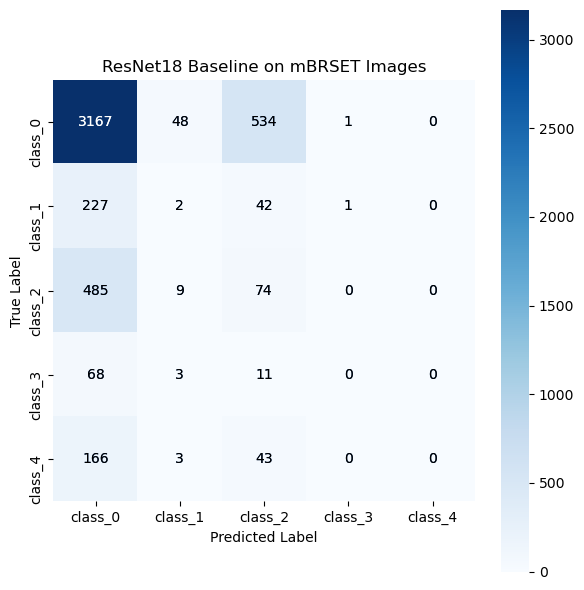

In [18]:
from common_functions import plot_cf
foo = plot_cf(preds, true, 'ResNet18 Baseline on mBRSET Images')

In [19]:
foo.savefig('baseline_cf', bbox_inches='tight', dpi=300)

In [54]:
print(f'Accuracy: {accuracy_score(true_labels.cpu(), predicted.cpu())}')
old: 0.20065520065520065

Accuracy: 0.20065520065520065


In [61]:
print(classification_report(true_labels.cpu(), predicted.cpu()))

              precision    recall  f1-score   support

           0       0.75      0.14      0.23      3750
           1       0.08      0.00      0.01       272
           2       0.11      0.81      0.20       568
           3       0.02      0.01      0.01        82
           4       0.00      0.00      0.00       212

    accuracy                           0.20      4884
   macro avg       0.19      0.19      0.09      4884
weighted avg       0.59      0.20      0.20      4884

